In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
addplant = pd.read_csv("add-plant.csv")
addplant.head()

,participant_id,condition,reaction_time,major_errors,minor_erros,clicks,confidence,outcome_certainty,perceived_speed,navigation_clarity,error_recovery_ease,group
0,2,A,6952,0,0,6,7,4,7,7,7,0
1,2,B,1862,0,0,3,7,7,7,7,7,0
2,3,A,4198,2,0,5,4,7,6,7,4,0
3,3,B,6498,0,0,3,6,7,6,6,7,0
4,12,A,4004,1,0,3,7,7,7,7,6,0


In [4]:
addplant["condition"] = addplant["condition"].astype("category")
addplant.dtypes

participant_id            int64
condition              category
reaction_time             int64
major_errors              int64
minor_erros               int64
clicks                    int64
confidence                int64
outcome_certainty         int64
perceived_speed           int64
navigation_clarity        int64
error_recovery_ease       int64
group                     int64
dtype: object

In [22]:
def paired_analysis(df, dv, id_col="participant_id", cond_col="condition",
                    a="A", b="B", title=None):
    """
    Paired t-test for within-subject A vs B + effect size dz + plots.
    """
    title = title or dv

    # 1) Wide format: one row per participant, columns A/B
    wide = df.pivot_table(index=id_col, columns=cond_col, values=dv, aggfunc="mean")
    wide = wide.dropna(subset=[a, b])  # keep only complete pairs
    n = len(wide)

    # 2) Differences
    diff = wide[a] - wide[b]

    # 3) Descriptives
    mean_a, sd_a = wide[a].mean(), wide[a].std(ddof=1)
    mean_b, sd_b = wide[b].mean(), wide[b].std(ddof=1)
    mean_diff, sd_diff = diff.mean(), diff.std(ddof=1)

    # 4) Paired t-test
    t, p = stats.ttest_rel(wide[a], wide[b])
    dfree = n - 1

    # 5) Effect size dz (paired)
    dz = mean_diff / sd_diff if sd_diff != 0 else np.nan

    # 6) 95% CI for mean difference (A-B)
    se = sd_diff / np.sqrt(n) if n > 0 else np.nan
    tcrit = stats.t.ppf(0.975, dfree) if n > 1 else np.nan
    ci_low = mean_diff - tcrit * se if n > 1 else np.nan
    ci_high = mean_diff + tcrit * se if n > 1 else np.nan

    # ---- Print a clean summary ----
    print(f"\n=== {title} ===")
    print(f"N (paired) = {n}")
    print(f"Mean {a} = {mean_a:.3f} (SD {sd_a:.3f})")
    print(f"Mean {b} = {mean_b:.3f} (SD {sd_b:.3f})")
    print(f"Mean diff ({a}-{b}) = {mean_diff:.3f} (SD {sd_diff:.3f})")
    print(f"Paired t-test: t({dfree}) = {t:.3f}, p = {p:.4f}")
    print(f"Effect size dz = {dz:.3f}")
    print(f"95% CI of mean diff = [{ci_low:.3f}, {ci_high:.3f}]")

    # ---- Plots (paired-friendly) ----
    # Plot 1: Paired lines (each participant)
    plt.figure()
    x = np.array([0, 1])
    for _, row in wide.iterrows():
        plt.plot(x, [row[a], row[b]], marker="o")
    plt.xticks([0, 1], [a, b])
    plt.title(f"{title}: paired values per participant")
    plt.xlabel("Condition")
    plt.ylabel(dv)
    plt.show()

    # Plot 2: Histogram of differences (A-B)
    plt.figure()
    plt.hist(diff, bins=8)
    plt.title(f"{title}: distribution of differences ({a}-{b})")
    plt.xlabel(f"{a}-{b}")
    plt.ylabel("Count")
    plt.show()

    return wide, diff

## Paired t-test for A vs B

reaction time


In [21]:
wide = addplant.pivot(index="participant_id", columns="condition", values="reaction_time")
t, p = stats.ttest_rel(wide["A"], wide["B"])
print("paired t-test reaction_time: t =", t, "p =", p)
print("means: A =", wide["A"].mean(), "B =", wide["B"].mean())

paired t-test reaction_time: t = 1.310539641559048 p = 0.21671645266788628
means: A = 5751.416666666667 B = 4393.916666666667



=== AddPlant: Reaction Time (ms) ===
N (paired) = 12
Mean A = 5751.417 (SD 2821.918)
Mean B = 4393.917 (SD 2482.567)
Mean diff (A-B) = 1357.500 (SD 3588.230)
Paired t-test: t(11) = 1.311, p = 0.2167
Effect size dz = 0.378
95% CI of mean diff = [-922.353, 3637.353]


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_4362/2723375514.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = df.pivot_table(index=id_col, columns=cond_col, values=dv, aggfunc="mean")


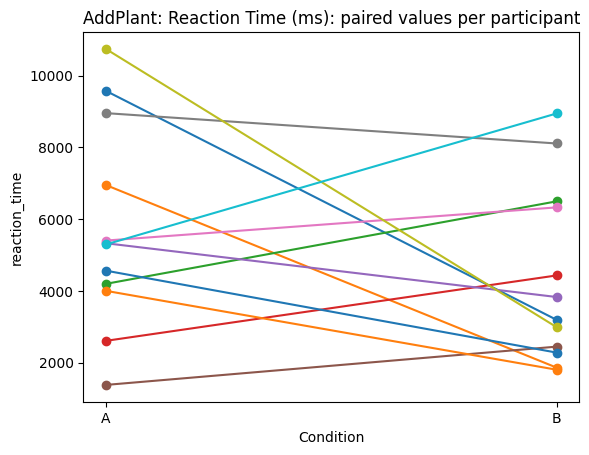

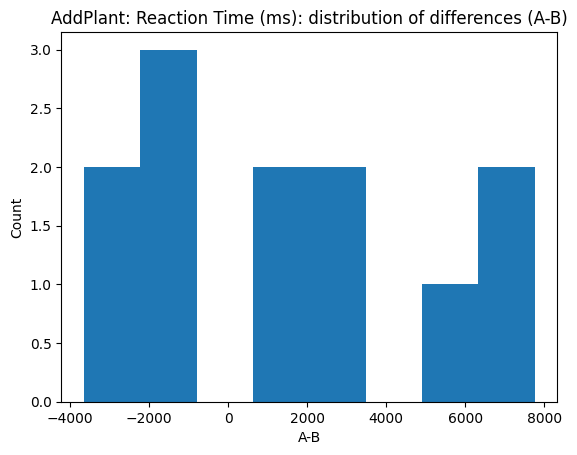

In [23]:
wide_rt, diff_rt = paired_analysis(addplant, "reaction_time", title="AddPlant: Reaction Time (ms)")

errors

In [5]:
addplant["errors"] = addplant["major_errors"] + (addplant["minor_erros"] / 2)
wide = addplant.pivot(index="participant_id", columns="condition", values="errors")
t, p = stats.ttest_rel(wide["A"], wide["B"])
print("paired t-test errors: t =", t, "p =", p)
print("means: A =", wide["A"].mean(), "B =", wide["B"].mean())

paired t-test errors: t = 0.32063022053099893 p = 0.7544993470226689
means: A = 0.3333333333333333 B = 0.25


clicks

In [6]:
wide = addplant.pivot(index="participant_id", columns="condition", values="clicks")
t, p = stats.ttest_rel(wide["A"], wide["B"])
print("paired t-test clicks: t =", t, "p =", p)
print("means: A =", wide["A"].mean(), "B =", wide["B"].mean())

paired t-test clicks: t = 0.6089224226894034 p = 0.5549427659576156
means: A = 3.5 B = 3.25


confidence

In [ ]:
wide = addplant.pivot(index="participant_id", columns="condition", values="confidence")
t, p = stats.ttest_rel(wide["A"], wide["B"])
print("paired t-test confidence: t =", t, "p =", p)
print("means: A =", wide["A"].mean(), "B =", wide["B"].mean())

paired t-test confidence: t = -1.1489125293076057 p = 0.27496148552409855
means: A = 6.5 B = 6.75


outcome_certainty

In [9]:
wide = addplant.pivot(index="participant_id", columns="condition", values="outcome_certainty")
t, p = stats.ttest_rel(wide["A"], wide["B"])
print("paired t-test outcome_certainty: t =", t, "p =", p)
print("means: A =", wide["A"].mean(), "B =", wide["B"].mean())

paired t-test outcome_certainty: t = -0.2897748533756077 p = 0.777377691724836
means: A = 6.75 B = 6.833333333333333


perceived_speed

In [10]:
wide = addplant.pivot(index="participant_id", columns="condition", values="perceived_speed")
t, p = stats.ttest_rel(wide["A"], wide["B"])
print("paired t-test perceived_speed: t =", t, "p =", p)
print("means: A =", wide["A"].mean(), "B =", wide["B"].mean())

paired t-test perceived_speed: t = 2.1589388479418643 p = 0.05380358204027793
means: A = 6.833333333333333 B = 6.416666666666667


navigation_clarity

In [11]:
wide = addplant.pivot(index="participant_id", columns="condition", values="navigation_clarity")
t, p = stats.ttest_rel(wide["A"], wide["B"])
print("paired t-test navigation_clarity: t =", t, "p =", p)
print("means: A =", wide["A"].mean(), "B =", wide["B"].mean())

paired t-test navigation_clarity: t = 1.3008872711759818 p = 0.21988784312755902
means: A = 7.0 B = 6.666666666666667


error_recovery_ease

In [12]:
wide = addplant.pivot(index="participant_id", columns="condition", values="error_recovery_ease")
t, p = stats.ttest_rel(wide["A"], wide["B"])
print("paired t-test error_recovery_ease: t =", t, "p =", p)
print("means: A =", wide["A"].mean(), "B =", wide["B"].mean())

paired t-test error_recovery_ease: t = -1.0 p = 0.3388006961962018
means: A = 6.666666666666667 B = 6.916666666666667


In [24]:
def order_effect_check(df, dv, group_col="group",
                       id_col="participant_id", cond_col="condition",
                       a="A", b="B", title=None):
    title = title or dv

    wide = df.pivot_table(index=id_col, columns=cond_col, values=dv, aggfunc="mean").reset_index()
    groups = df[[id_col, group_col]].drop_duplicates(id_col)
    wide = wide.merge(groups, on=id_col, how="left")
    wide = wide.dropna(subset=[a, b])

    wide["diff_A_minus_B"] = wide[a] - wide[b]

    g0 = wide.loc[wide[group_col] == 0, "diff_A_minus_B"]
    g1 = wide.loc[wide[group_col] == 1, "diff_A_minus_B"]

    print(f"\n=== Order effect: {title} ===")
    print("n group0 =", len(g0), "n group1 =", len(g1))
    print("mean diff group0 =", g0.mean(), "mean diff group1 =", g1.mean())

    t, p = stats.ttest_ind(g0, g1, equal_var=False)  # Welch
    print(f"Welch t-test on diffs: t = {t:.3f}, p = {p:.4f}")

    # Plot: diffs by order group
    plt.figure()
    plt.boxplot([g0.dropna(), g1.dropna()], labels=["group0 (A first)", "group1 (B first)"])
    plt.title(f"{title}: differences (A-B) by order group")
    plt.ylabel(f"{a}-{b}")
    plt.show()

    return wide

## order effect check

reaction time

In [ ]:

wide = addplant.pivot_table(
    index="participant_id",
    columns="condition",
    values="reaction_time",
    aggfunc="mean"
).reset_index()

groups = addplant[["participant_id", "group"]].drop_duplicates("participant_id")
wide = wide.merge(groups, on="participant_id", how="left")

wide = wide.dropna(subset=["A", "B"])

wide["diff_A_minus_B"] = wide["A"] - wide["B"]

g0 = wide.loc[wide["group"] == 0, "diff_A_minus_B"]
g1 = wide.loc[wide["group"] == 1, "diff_A_minus_B"]

print("n group0 =", len(g0), "n group1 =", len(g1))
print("mean diff group0 =", g0.mean(), "mean diff group1 =", g1.mean())

t, p = stats.ttest_ind(g0, g1, equal_var=False)
print("order effect on diff (Welch): t =", t, "p =", p)

n group0 = 7 n group1 = 5
mean diff group0 = 1904.5714285714287 mean diff group1 = 591.6
order effect on diff (Welch): t = 0.5756785320996402 p = 0.5826856984144262


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_22020/4237587484.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = addplant.pivot_table(



=== Order effect: AddPlant: Reaction Time (ms) ===
n group0 = 7 n group1 = 5
mean diff group0 = 1904.5714285714287 mean diff group1 = 591.6
Welch t-test on diffs: t = 0.576, p = 0.5827


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_4362/724638157.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = df.pivot_table(index=id_col, columns=cond_col, values=dv, aggfunc="mean").reset_index()
/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_4362/724638157.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([g0.dropna(), g1.dropna()], labels=["group0 (A first)", "group1 (B first)"])


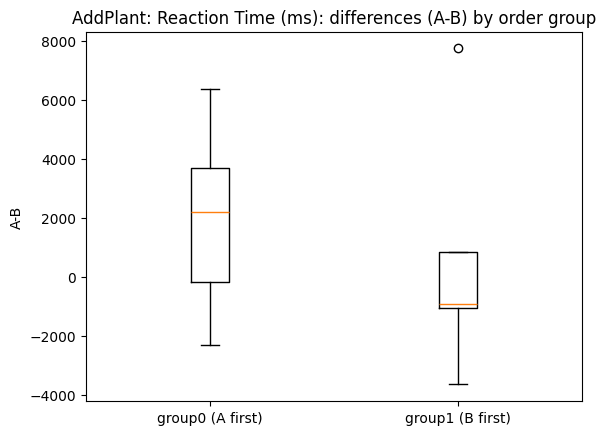

,participant_id,A,B,group,diff_A_minus_B
0,1,9576.0,3193.0,0,6383.0
1,2,6952.0,1862.0,0,5090.0
2,3,4198.0,6498.0,0,-2300.0
3,4,2610.0,4433.0,0,-1823.0
4,5,5330.0,3831.0,0,1499.0
5,6,1382.0,2449.0,1,-1067.0
6,7,5404.0,6329.0,1,-925.0
7,8,8955.0,8109.0,1,846.0
8,9,10744.0,2989.0,1,7755.0
9,10,5296.0,8947.0,1,-3651.0


In [25]:
order_effect_check(addplant, "reaction_time", title="AddPlant: Reaction Time (ms)")

errors

In [13]:

wide = addplant.pivot_table(
    index="participant_id",
    columns="condition",
    values="errors",
    aggfunc="mean"
).reset_index()

groups = addplant[["participant_id", "group"]].drop_duplicates("participant_id")
wide = wide.merge(groups, on="participant_id", how="left")

wide = wide.dropna(subset=["A", "B"])

wide["diff_A_minus_B"] = wide["A"] - wide["B"]

g0 = wide.loc[wide["group"] == 0, "diff_A_minus_B"]
g1 = wide.loc[wide["group"] == 1, "diff_A_minus_B"]

print("n group0 =", len(g0), "n group1 =", len(g1))
print("mean diff group0 =", g0.mean(), "mean diff group1 =", g1.mean())

t, p = stats.ttest_ind(g0, g1, equal_var=False)
print("order effect on diff (Welch): t =", t, "p =", p)

n group0 = 7 n group1 = 5
mean diff group0 = 0.14285714285714285 mean diff group1 = 0.0
order effect on diff (Welch): t = 0.3110855084191276 p = 0.7662600657593479


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_4362/3401044036.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = addplant.pivot_table(


clicks

In [14]:
wide = addplant.pivot_table(
    index="participant_id",
    columns="condition",
    values="clicks",
    aggfunc="mean"
).reset_index()

groups = addplant[["participant_id", "group"]].drop_duplicates("participant_id")
wide = wide.merge(groups, on="participant_id", how="left")

wide = wide.dropna(subset=["A", "B"])

wide["diff_A_minus_B"] = wide["A"] - wide["B"]

g0 = wide.loc[wide["group"] == 0, "diff_A_minus_B"]
g1 = wide.loc[wide["group"] == 1, "diff_A_minus_B"]

print("n group0 =", len(g0), "n group1 =", len(g1))
print("mean diff group0 =", g0.mean(), "mean diff group1 =", g1.mean())

t, p = stats.ttest_ind(g0, g1, equal_var=False)
print("order effect on diff (Welch): t =", t, "p =", p)

n group0 = 7 n group1 = 5
mean diff group0 = 0.42857142857142855 mean diff group1 = 0.0
order effect on diff (Welch): t = 0.5960395606792697 p = 0.5729317850717073


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_4362/2533078345.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = addplant.pivot_table(


confidence

In [15]:
wide = addplant.pivot_table(
    index="participant_id",
    columns="condition",
    values="confidence",
    aggfunc="mean"
).reset_index()

groups = addplant[["participant_id", "group"]].drop_duplicates("participant_id")
wide = wide.merge(groups, on="participant_id", how="left")

wide = wide.dropna(subset=["A", "B"])

wide["diff_A_minus_B"] = wide["A"] - wide["B"]

g0 = wide.loc[wide["group"] == 0, "diff_A_minus_B"]
g1 = wide.loc[wide["group"] == 1, "diff_A_minus_B"]

print("n group0 =", len(g0), "n group1 =", len(g1))
print("mean diff group0 =", g0.mean(), "mean diff group1 =", g1.mean())

t, p = stats.ttest_ind(g0, g1, equal_var=False)
print("order effect on diff (Welch): t =", t, "p =", p)

n group0 = 7 n group1 = 5
mean diff group0 = -0.42857142857142855 mean diff group1 = 0.0
order effect on diff (Welch): t = -1.161895003862225 p = 0.2894032248467901


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_4362/252020605.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = addplant.pivot_table(


outcome_certainty

In [16]:
wide = addplant.pivot_table(
    index="participant_id",
    columns="condition",
    values="outcome_certainty",
    aggfunc="mean"
).reset_index()

groups = addplant[["participant_id", "group"]].drop_duplicates("participant_id")
wide = wide.merge(groups, on="participant_id", how="left")

wide = wide.dropna(subset=["A", "B"])

wide["diff_A_minus_B"] = wide["A"] - wide["B"]

g0 = wide.loc[wide["group"] == 0, "diff_A_minus_B"]
g1 = wide.loc[wide["group"] == 1, "diff_A_minus_B"]

print("n group0 =", len(g0), "n group1 =", len(g1))
print("mean diff group0 =", g0.mean(), "mean diff group1 =", g1.mean())

t, p = stats.ttest_ind(g0, g1, equal_var=False)
print("order effect on diff (Welch): t =", t, "p =", p)

n group0 = 7 n group1 = 5
mean diff group0 = -0.42857142857142855 mean diff group1 = 0.4
order effect on diff (Welch): t = -1.6785173325023746 p = 0.12717198903057056


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_4362/362847905.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = addplant.pivot_table(


perceived_speed

In [17]:
wide = addplant.pivot_table(
    index="participant_id",
    columns="condition",
    values="perceived_speed",
    aggfunc="mean"
).reset_index()

groups = addplant[["participant_id", "group"]].drop_duplicates("participant_id")
wide = wide.merge(groups, on="participant_id", how="left")

wide = wide.dropna(subset=["A", "B"])

wide["diff_A_minus_B"] = wide["A"] - wide["B"]

g0 = wide.loc[wide["group"] == 0, "diff_A_minus_B"]
g1 = wide.loc[wide["group"] == 1, "diff_A_minus_B"]

print("n group0 =", len(g0), "n group1 =", len(g1))
print("mean diff group0 =", g0.mean(), "mean diff group1 =", g1.mean())

t, p = stats.ttest_ind(g0, g1, equal_var=False)
print("order effect on diff (Welch): t =", t, "p =", p)

n group0 = 7 n group1 = 5
mean diff group0 = 0.42857142857142855 mean diff group1 = 0.4
order effect on diff (Welch): t = 0.07415889498137032 p = 0.9423465365013336


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_4362/2482791086.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = addplant.pivot_table(


navigation_clarity

In [18]:
wide = addplant.pivot_table(
    index="participant_id",
    columns="condition",
    values="navigation_clarity",
    aggfunc="mean"
).reset_index()

groups = addplant[["participant_id", "group"]].drop_duplicates("participant_id")
wide = wide.merge(groups, on="participant_id", how="left")

wide = wide.dropna(subset=["A", "B"])

wide["diff_A_minus_B"] = wide["A"] - wide["B"]

g0 = wide.loc[wide["group"] == 0, "diff_A_minus_B"]
g1 = wide.loc[wide["group"] == 1, "diff_A_minus_B"]

print("n group0 =", len(g0), "n group1 =", len(g1))
print("mean diff group0 =", g0.mean(), "mean diff group1 =", g1.mean())

t, p = stats.ttest_ind(g0, g1, equal_var=False)
print("order effect on diff (Welch): t =", t, "p =", p)

n group0 = 7 n group1 = 5
mean diff group0 = 0.5714285714285714 mean diff group1 = 0.0
order effect on diff (Welch): t = 1.3333333333333333 p = 0.23080940884182116


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_4362/307408635.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = addplant.pivot_table(


error_recovery_ease

In [19]:
wide = addplant.pivot_table(
    index="participant_id",
    columns="condition",
    values="error_recovery_ease",
    aggfunc="mean"
).reset_index()

groups = addplant[["participant_id", "group"]].drop_duplicates("participant_id")
wide = wide.merge(groups, on="participant_id", how="left")

wide = wide.dropna(subset=["A", "B"])

wide["diff_A_minus_B"] = wide["A"] - wide["B"]

g0 = wide.loc[wide["group"] == 0, "diff_A_minus_B"]
g1 = wide.loc[wide["group"] == 1, "diff_A_minus_B"]

print("n group0 =", len(g0), "n group1 =", len(g1))
print("mean diff group0 =", g0.mean(), "mean diff group1 =", g1.mean())

t, p = stats.ttest_ind(g0, g1, equal_var=False)
print("order effect on diff (Welch): t =", t, "p =", p)

n group0 = 7 n group1 = 5
mean diff group0 = -0.42857142857142855 mean diff group1 = 0.0
order effect on diff (Welch): t = -0.9999999999999999 p = 0.35591768374958205


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_4362/2826809642.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = addplant.pivot_table(
